In [4]:
import numpy as np 
import sympy as sym
from typing import Tuple

In [5]:
class Flat_Layout: 
  def __init__ (self, input_symbol:str, middle_symbol:str, marker:str, shape, stride): 
    assert len(shape) == len(stride) 
    self.length = len(shape)
    self.size = np.prod(shape).item()
    self.name = marker
    self.middle_sym = middle_symbol
    self.shape = [sym.Integer(s) for s in shape] 
    self.stride = [sym.Integer(d) for d in stride]
    self.co_size = (1  + np.sum(np.array(stride)*(np.array(shape)-1))).item()
    self.S = [sym.Symbol(f"s^{self.name}_{i}") for i in range(self.length)]
    self.D = [sym.Symbol(f"d^{self.name}_{i}") for i in range(self.length)]
    self.input_sym = sym.Symbol(input_symbol)
    self.SS = [sym.Integer(1) for _ in range(self.length)]
    for i in range(1, self.length): 
      self.SS[i] = self.S[i-1]*self.SS[i-1]
    
    self.colex_inv_sym = tuple([(self.input_sym // self.SS[i]) % self.S[i] for i in range(self.length)])
    self.co_ordinate_tuple = tuple([sym.Symbol(f"{self.middle_sym}^{self.name}_{i}") for i in range(self.length)])
    self.co_ordinate_map_sym = sum([self.co_ordinate_tuple[i]*self.D[i] for i in range(self.length)])
    self.layout_map_sym = self._substitute(self.co_ordinate_map_sym, self.colex_inv_sym, self.co_ordinate_tuple)
    
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    
    self.colex_inv = []
  
    for i in range(self.length): 
      self.colex_inv.append(self._substitute(self.colex_inv_sym[i], self.shape, self.S))
      
    self.co_ordinate_map = self._substitute(self.co_ordinate_map_sym, self.stride, self.D)
    self.layout_map = self._substitute(self.layout_map_sym, self.shape, self.S)
    self.layout_map = self._substitute(self.layout_map, self.stride, self.D)
    
    

In [6]:
shape = (3,4,2,7)
stride = (1,13,9,5)
col_stride = (1,3,12,24)
x,y,z,w = (0,1,3,2)

L = Flat_Layout("x", "y", "", shape, stride)
L_perm = Flat_Layout("v", "w", "p", (shape[x], shape[y], shape[z], shape[w]), 
                     (stride[x], stride[y], stride[z], stride[w]))

col_perm = Flat_Layout("t", "h", "c",  (shape[x], shape[y], shape[z], shape[w]),
                       (col_stride[x], col_stride[y], col_stride[z], col_stride[w]))

In [7]:
L.realize()
L_perm.realize()
col_perm.realize()

In [8]:
phi_L = L.layout_map
phi_col_perm = col_perm.layout_map 
phi_L_perm = L_perm.layout_map

In [9]:
phi_L

5*(Mod(floor(x/24), 7)) + 9*(Mod(floor(x/12), 2)) + 13*(Mod(floor(x/3), 4)) + Mod(floor(x), 3)

In [10]:
phi_col_perm

12*(Mod(floor(t/84), 2)) + 24*(Mod(floor(t/12), 7)) + 3*(Mod(floor(t/3), 4)) + Mod(floor(t), 3)

In [11]:
phi_L_perm

9*(Mod(floor(v/84), 2)) + 5*(Mod(floor(v/12), 7)) + 13*(Mod(floor(v/3), 4)) + Mod(floor(v), 3)

In [12]:
old_symbol = tuple([L.input_sym]) 
new_symbol = tuple([phi_col_perm])
expression = phi_L

In [13]:
X = L._substitute(expression, new_symbol, old_symbol)
X

5*(Mod(floor((Mod(floor(t/84), 2))/2 + Mod(floor(t/12), 7) + (Mod(floor(t/3), 4))/8 + (Mod(floor(t), 3))/24), 7)) + 9*(Mod(floor(Mod(floor(t/84), 2) + 2*(Mod(floor(t/12), 7)) + (Mod(floor(t/3), 4))/4 + (Mod(floor(t), 3))/12), 2)) + 13*(Mod(floor(4*(Mod(floor(t/84), 2)) + 8*(Mod(floor(t/12), 7)) + Mod(floor(t/3), 4) + (Mod(floor(t), 3))/3), 4)) + Mod(floor(12*(Mod(floor(t/84), 2)) + 24*(Mod(floor(t/12), 7)) + 3*(Mod(floor(t/3), 4)) + Mod(floor(t), 3)), 3)

In [14]:
def evaluate (expression, domain, input_symbol): 
  np_domain = np.arange(domain) 
  expression_lambda = sym.lambdify(input_symbol, expression, "numpy")
  return expression_lambda(np_domain).astype(int)
    
  

In [15]:
X_eval = evaluate(X, L.size, col_perm.input_sym)

In [16]:
X_eval

array([ 0,  1,  2, 13, 14, 15, 26, 27, 28, 39, 40, 41,  5,  6,  7, 18, 19,
       20, 31, 32, 33, 44, 45, 46, 10, 11, 12, 23, 24, 25, 36, 37, 38, 49,
       50, 51, 15, 16, 17, 28, 29, 30, 41, 42, 43, 54, 55, 56, 20, 21, 22,
       33, 34, 35, 46, 47, 48, 59, 60, 61, 25, 26, 27, 38, 39, 40, 51, 52,
       53, 64, 65, 66, 30, 31, 32, 43, 44, 45, 56, 57, 58, 69, 70, 71,  9,
       10, 11, 22, 23, 24, 35, 36, 37, 48, 49, 50, 14, 15, 16, 27, 28, 29,
       40, 41, 42, 53, 54, 55, 19, 20, 21, 32, 33, 34, 45, 46, 47, 58, 59,
       60, 24, 25, 26, 37, 38, 39, 50, 51, 52, 63, 64, 65, 29, 30, 31, 42,
       43, 44, 55, 56, 57, 68, 69, 70, 34, 35, 36, 47, 48, 49, 60, 61, 62,
       73, 74, 75, 39, 40, 41, 52, 53, 54, 65, 66, 67, 78, 79, 80])

In [17]:
L_perm_eval = evaluate(phi_L_perm, L.size, L_perm.input_sym)

In [18]:
L_perm_eval

array([ 0,  1,  2, 13, 14, 15, 26, 27, 28, 39, 40, 41,  5,  6,  7, 18, 19,
       20, 31, 32, 33, 44, 45, 46, 10, 11, 12, 23, 24, 25, 36, 37, 38, 49,
       50, 51, 15, 16, 17, 28, 29, 30, 41, 42, 43, 54, 55, 56, 20, 21, 22,
       33, 34, 35, 46, 47, 48, 59, 60, 61, 25, 26, 27, 38, 39, 40, 51, 52,
       53, 64, 65, 66, 30, 31, 32, 43, 44, 45, 56, 57, 58, 69, 70, 71,  9,
       10, 11, 22, 23, 24, 35, 36, 37, 48, 49, 50, 14, 15, 16, 27, 28, 29,
       40, 41, 42, 53, 54, 55, 19, 20, 21, 32, 33, 34, 45, 46, 47, 58, 59,
       60, 24, 25, 26, 37, 38, 39, 50, 51, 52, 63, 64, 65, 29, 30, 31, 42,
       43, 44, 55, 56, 57, 68, 69, 70, 34, 35, 36, 47, 48, 49, 60, 61, 62,
       73, 74, 75, 39, 40, 41, 52, 53, 54, 65, 66, 67, 78, 79, 80])

In [38]:
s = (3,7,12)
d = (13,9,5)

perm = (1,0,2)
x,y,z = perm

s_perm = (s[x], s[y], s[z])
d_perm = (d[x], d[y], d[z])


print(f"{s}:{d} \n {s_perm}:{d_perm}")

L = Flat_Layout("x", "y", "f", s, d) 
L_perm = Flat_Layout("x", "y", "g", s_perm, d_perm)


(3, 7, 12):(13, 9, 5) 
 (7, 3, 12):(9, 13, 5)


In [39]:
L.realize()
L_perm.realize()

In [40]:
L_coord = L.co_ordinate_map
L_perm_coord = L_perm.co_ordinate_map

In [41]:
L_coord

13*y^f_0 + 9*y^f_1 + 5*y^f_2

In [42]:
L_perm_coord

9*y^g_0 + 13*y^g_1 + 5*y^g_2

In [43]:
def make_isomoprhism(perm, co_ord_sym_tup): 
  assert len(perm) == len(co_ord_sym_tup)
  m = len(perm) 
  for i in range(m): 
    assert 0 <= perm[i] 
    assert perm[i] < m 
    
  assert m == np.size(np.unique(np.array(perm)))
  
  perm_co_ords = tuple([co_ord_sym_tup[perm[i]] for i in range(m)])
  return perm_co_ords 
  
  
  
  

In [44]:
permuted_co_ordinate_sym = make_isomoprhism(perm, L.co_ordinate_tuple)

In [45]:
permuted_co_ordinate_sym

(y^f_1, y^f_0, y^f_2)

In [46]:
L.co_ordinate_tuple

(y^f_0, y^f_1, y^f_2)

In [47]:
def percompose_isomorphism (co_ordinate_map_expression, old_co_ordinate_tuple, new_co_ordinate_tuple): 
  new_expr = co_ordinate_map_expression
  for i in range(len(old_co_ordinate_tuple)): 
    new_expr = new_expr.subs(old_co_ordinate_tuple[i], new_co_ordinate_tuple[i])
    
  return new_expr
  

In [48]:
L_perm_coord_after_perm = percompose_isomorphism(L_perm_coord, L_perm.co_ordinate_tuple, permuted_co_ordinate_sym)

In [49]:
L_coord

13*y^f_0 + 9*y^f_1 + 5*y^f_2

In [51]:
L_perm_coord

9*y^g_0 + 13*y^g_1 + 5*y^g_2

In [50]:
L_perm_coord_after_perm

13*y^f_0 + 9*y^f_1 + 5*y^f_2

In [58]:
class permuted_C_maps: 
  def __init__ (self, shape, stride, perm): 
    
    m = len(perm)
    shape_perm = tuple([shape[perm[i]] for i in range(m)])
    stride_perm = tuple([stride[perm[i]] for i in range(m)])
    
    L = Flat_Layout("x", "y", "f", shape, stride) 
    L_perm = Flat_Layout("x", "y", "g", shape_perm, stride_perm) 
    L.realize()
    L_perm.realize()
    L_coord = L.co_ordinate_map
    L_perm_coord = L_perm.co_ordinate_map 
    permuted_co_ordinate_sym = self._make_isomoprhism(perm, L.co_ordinate_tuple)
    L_perm_coord_after_iso = self._percompose_isomorphism(L_perm_coord, L_perm.co_ordinate_tuple, permuted_co_ordinate_sym)
    
    self.L_coord = L_coord
    self.L_perm_coord = L_perm_coord
    self.L_perm_coord_after_iso = L_perm_coord_after_iso
    
  def __repr__(self):
    return f"L_coord_map: {sym.latex(self.L_coord)} \n L^permuted_coord_map : {sym.latex(self.L_perm_coord)} \n L^permuted_coord_map_after_iso: {sym.latex(self.L_perm_coord_after_iso)}"
  
    
    
  def _make_isomoprhism(self, perm, co_ord_sym_tup): 
    assert len(perm) == len(co_ord_sym_tup)
    m = len(perm) 
    for i in range(m): 
      assert 0 <= perm[i] 
      assert perm[i] < m 
      
    assert m == np.size(np.unique(np.array(perm)))
    
    perm_co_ords = tuple([co_ord_sym_tup[perm[i]] for i in range(m)])
    return perm_co_ords 
    
  def _percompose_isomorphism (self, co_ordinate_map_expression, old_co_ordinate_tuple, new_co_ordinate_tuple): 
    new_expr = co_ordinate_map_expression
    for i in range(len(old_co_ordinate_tuple)): 
      new_expr = new_expr.subs(old_co_ordinate_tuple[i], new_co_ordinate_tuple[i])
      
    return new_expr

In [65]:
shape = (15,2,17,5,7)
stride = (9,3,4,13,6)
perm = (0,4,1,3,2)
perm_verifier = permuted_C_maps(shape, stride, perm)

In [66]:
perm_verifier

L_coord_map: 9 y^{f}_{0} + 3 y^{f}_{1} + 4 y^{f}_{2} + 13 y^{f}_{3} + 6 y^{f}_{4} 
 L^permuted_coord_map : 9 y^{g}_{0} + 6 y^{g}_{1} + 3 y^{g}_{2} + 13 y^{g}_{3} + 4 y^{g}_{4} 
 L^permuted_coord_map_after_iso: 9 y^{f}_{0} + 3 y^{f}_{1} + 4 y^{f}_{2} + 13 y^{f}_{3} + 6 y^{f}_{4}

In [67]:
perm_verifier.L_coord

In [68]:
perm_verifier.L_perm_coord_after_iso

In [63]:
perm_verifier.L_perm_coord

In [70]:
class permuted_colex_inv_maps: 
  def __init__ (self, shape, stride, perm): 
    
    m = len(perm)
    shape_perm = tuple([shape[perm[i]] for i in range(m)])
    stride_perm = tuple([stride[perm[i]] for i in range(m)])
    
    L = Flat_Layout("x", "y", "f", shape, stride) 
    L_perm = Flat_Layout("x", "y", "g", shape_perm, stride_perm) 
    L.realize()
    L_perm.realize()
    self.L_colex_inv = L.colex_inv
    self.L_perm_colex_inv = L_perm.colex_inv
    

In [71]:
A = permuted_colex_inv_maps(shape,stride, perm)

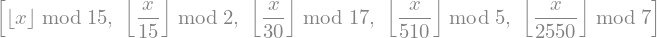

In [73]:
A.L_colex_inv

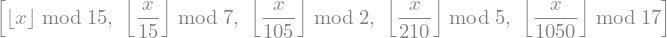

In [74]:
A.L_perm_colex_inv